### Apache 2.0 License

In [ ]:
"""
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

### Importing Core Imaging Library

In [1]:
import cil
print(f'cil.__version__ = {cil.__version__}')

cil.__version__ = 24.3.0


### Import all the necessary libraries for the reconstruction

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from cil.framework import AcquisitionGeometry
from cil.optimisation.functions import LeastSquares, TotalVariation, L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import BlockOperator, GradientOperator
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.algorithms import FISTA, PDHG, SPDHG
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io import TIFFStackReader

/home/sami/miniconda3/envs/cil/lib/python3.12/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Read keyboard PCA datafile for parameters

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from util.pcaReader import read_pca_file

filepath = 'keyboard_1/keyboard.pca'
params = read_pca_file(filepath)

196 lines, found 143 values (discarded 124)


Scan setting

In [4]:
SOD = params['FOD'] # Source-Origin-distance
SDD = params['FDD'] # Source-Detector-distance
ODD = SDD - SOD # Origin-Detector-distance

print(f'SOD: {SOD:.3f} mm')
print(f'SDD: {SDD:.3f} mm')
print(f'ODD: {ODD:.3f} mm')

pixel_size = 200 / 1000
print(f'Detector pixel size: {pixel_size:.3f} mm')

num_pixels = (params['DimX'], params['DimY']) # Width and height of the projection image
num_pixels = (num_pixels[0], num_pixels[1])
print(f'The original size of the projection image: {params['DimX']} x {params['DimY']}, set to {num_pixels[0]} x {num_pixels[1]}')

# Projections
num_projs = params['NumberImages']
print(f'{num_projs} projection angles used')


SOD: 150.595 mm
SDD: 648.629 mm
ODD: 498.035 mm
Detector pixel size: 0.200 mm
The original size of the projection image: 1000.0 x 1000.0, set to 1000.0 x 1000.0
1080 projection angles used


Detector and rotation angles

In [5]:
skip = 10 # Donwsampling constant for projections
angles = np.linspace(0, 360, num_projs//skip, endpoint=False) # Downsampled angles

ag_big = AcquisitionGeometry.create_Cone3D(
    source_position=[0, -SOD, 0],
    detector_position=[0, ODD, 0],
    units='mm',
    detector_direction_x=[1, 0, 0],
    rotation_axis_direction=[0,0,1],  
)

ag_big.set_panel(
    num_pixels=num_pixels,
    pixel_size=(pixel_size,pixel_size),
    origin='bottom-right'
    )

ag_big.set_angles(angles)
ag_big.set_labels(('angle', 'vertical', 'horizontal'))
print(ag_big)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -150.59470833,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 498.03460667,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 108
	Angles 0-9 in degrees: [ 0.       ,  3.3333333,  6.6666665, 10.       , 13.333333 , 16.666666 ,
 20.       , 23.333334 , 26.666666 , 30.       ]
	Angles 98-107 in degrees: [326.66666, 330.     , 333.33334, 336.66666, 340.     , 343.33334,
 346.66666, 350.     , 353.33334, 356.66666]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


Read the .tif files

Number of dimensions: 3
Shape: (108, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



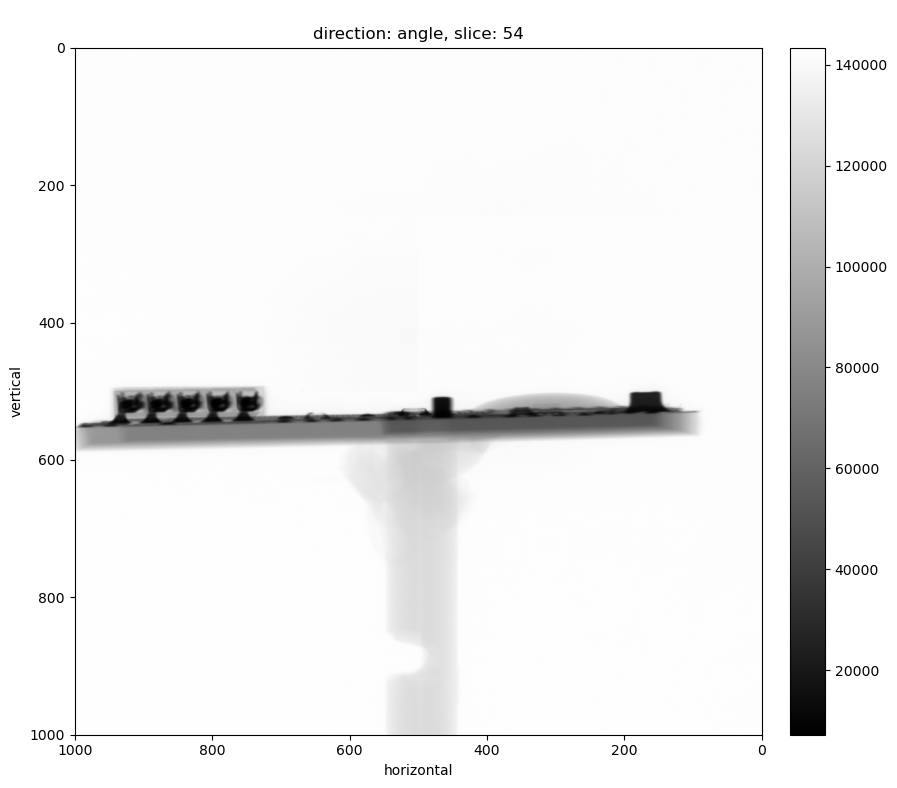

In [6]:
# Region of interest
roi = {'axis_0': (0, num_projs, skip), 'axis_1': -1, 'axis_2': (0, 1000,1)}
reader = TIFFStackReader(file_name='keyboard_1', transpose=False, roi=roi)
big_raw_data = reader.read_as_AcquisitionData(ag_big)
del reader
print(big_raw_data)
show2D(datacontainers=big_raw_data, origin='upper-right');

Processing transmission images to absorption images

max_k = 14357, about 87.628 of the maximum (of 14 bit int)


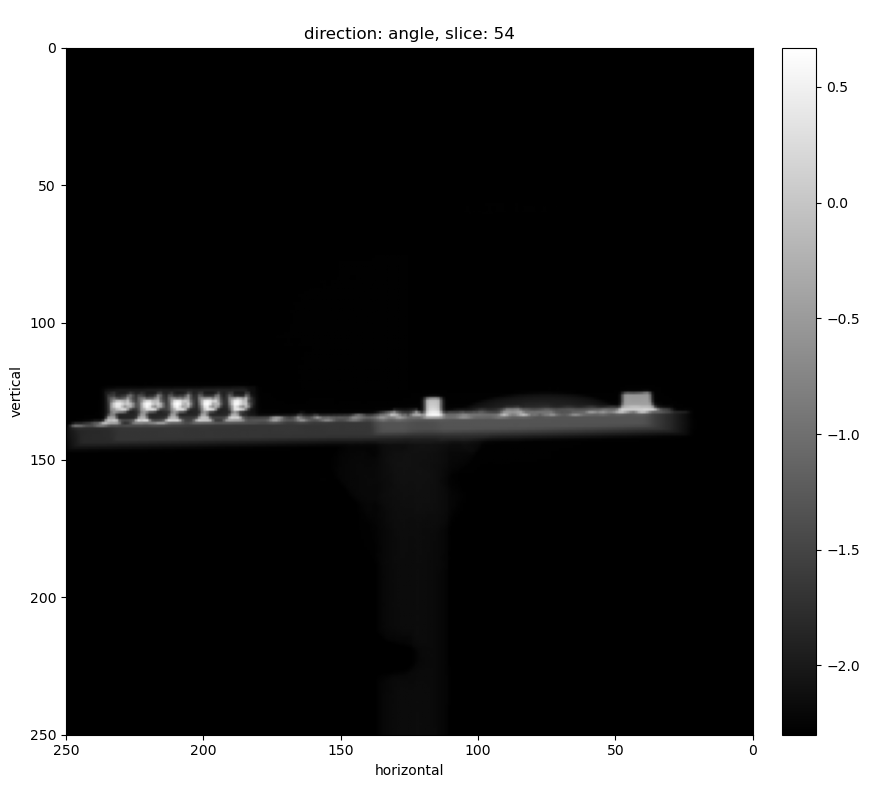

Number of dimensions: 3
Shape: (108, 250, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [7]:
from cil.processors import Binner, TransmissionAbsorptionConverter

binning = 4 # Downsampling constant
binner_processor = Binner(roi={'horizontal': (None, None, binning), 'vertical': (None, None, binning)})
binner_processor.set_input(big_raw_data)

# Binned data
data = binner_processor.get_output()

max_k = params['FreeRay'] # Maximum intensity
print(f'{max_k = }, about {100*max_k / 2**14:.3f} of the maximum (of 14 bit int)')
transmission_processor = TransmissionAbsorptionConverter(white_level=max_k)
transmission_processor.set_input(data)
transmission_processor.get_output(out=data)

show2D(data, origin='upper-right')
print(data)

In [8]:
islicer(data, direction=0)
# show2D(data, origin='upper-right')


In [9]:
# Delete unnecessary thing to free memory
del big_raw_data
del binner_processor
del transmission_processor

Image geometry

In [10]:
# Setup for the image geometry
(_, nz, nx) = data.shape

# Image geometry
ig = data.geometry.get_ImageGeometry()
ig.voxel_num_x = nx
ig.voxel_num_y = nx
ig.voxel_num_z = nz
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x250,y250,z250
voxel_size : x0.1857390097516638,y0.1857390097516638,z0.1857390097516638
center : x0,y0,z0



### CT-reconstructions

Feldkamp-Davis-Kress (FDK) reconstruction

In [32]:
from cil.recon import FDK

# data.reorder('tigre')
data.reorder('tigre')
fdk = FDK(data, image_geometry=ig, filter='ram-lak')
# fdk = FDK(data)

fdk_recon = fdk.run()

FDK recon

Input Data:
	angle: 108
	vertical: 250
	horizontal: 250

Reconstruction Volume:
	vertical: 250
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False



(250, 250, 250)


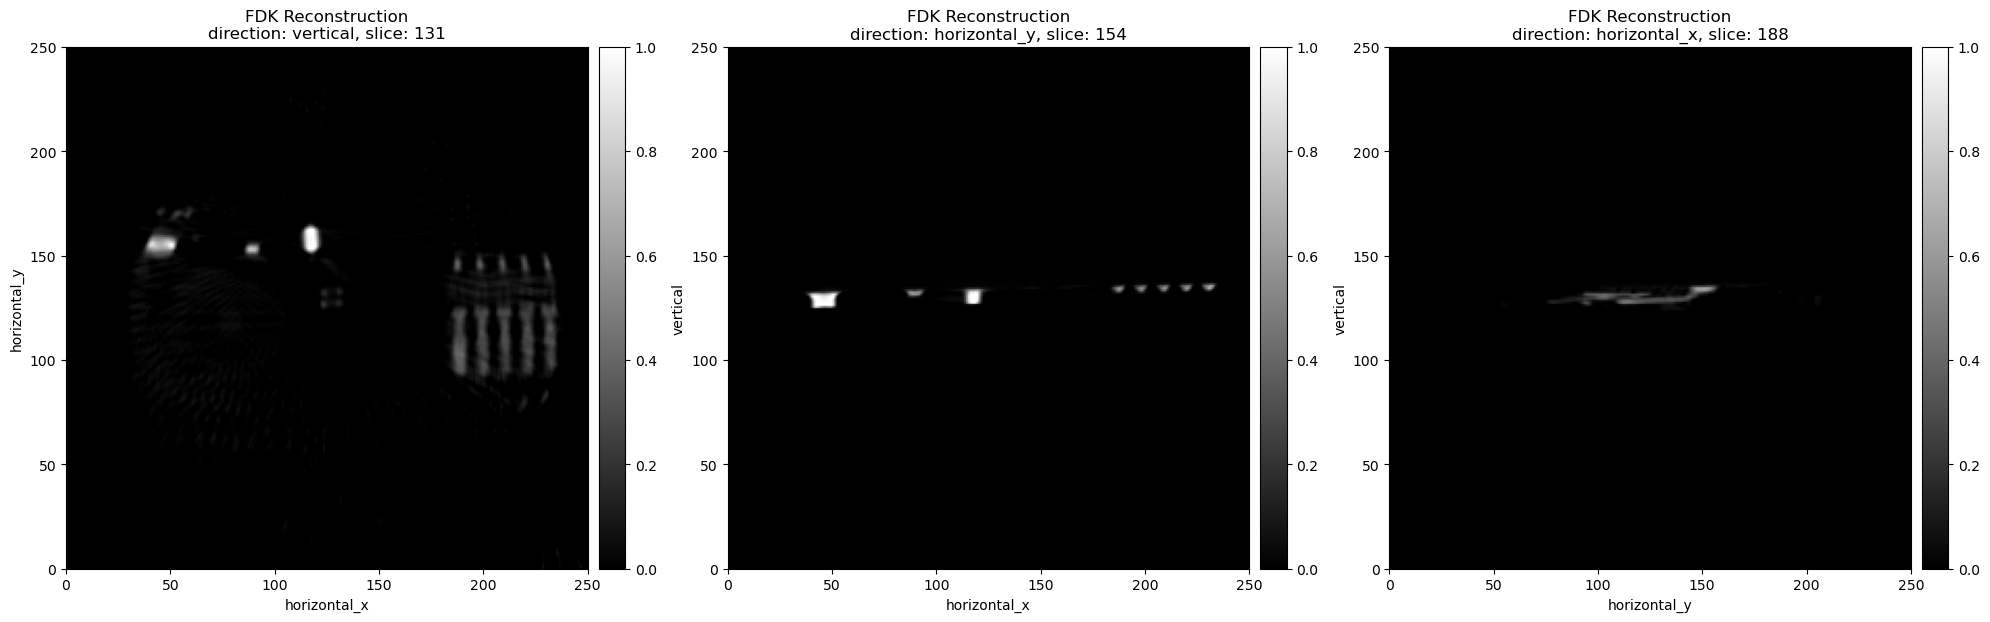

In [33]:
lb = 0 # lower bound
ub = 1 # upper bound
print(fdk_recon.shape)
ub = 1 # Upper bound
show2D(fdk_recon, size=(20,10), fix_range=(lb,ub), cmap='gray', title=f'FDK Reconstruction', num_cols=3, slice_list=[(0, 131), (1, 154), (2, 188)]);

In [13]:
islicer(fdk_recon, minmax=(lb,ub), direction=0, cmap='gray')


Total Variation (TV) reconstruction using FISTA

In [14]:
data.reorder('astra') # Changing backend

# Acquisition geometry
ag = data.geometry

A = ProjectionOperator(ig, ag, 'gpu')
f = LeastSquares(A, data)
h = TotalVariation()
x0 = ig.allocate(0) # Starting point

# alpha = 1e-5 # Regulazation constant
alpha = 1e-5

tv_fista = FISTA(initial=x0, f=f, g=alpha*h) # Setting up FISTA algorithm

tv_fista.run(20)

  0%|          | 0/20 [00:00<?, ?it/s]

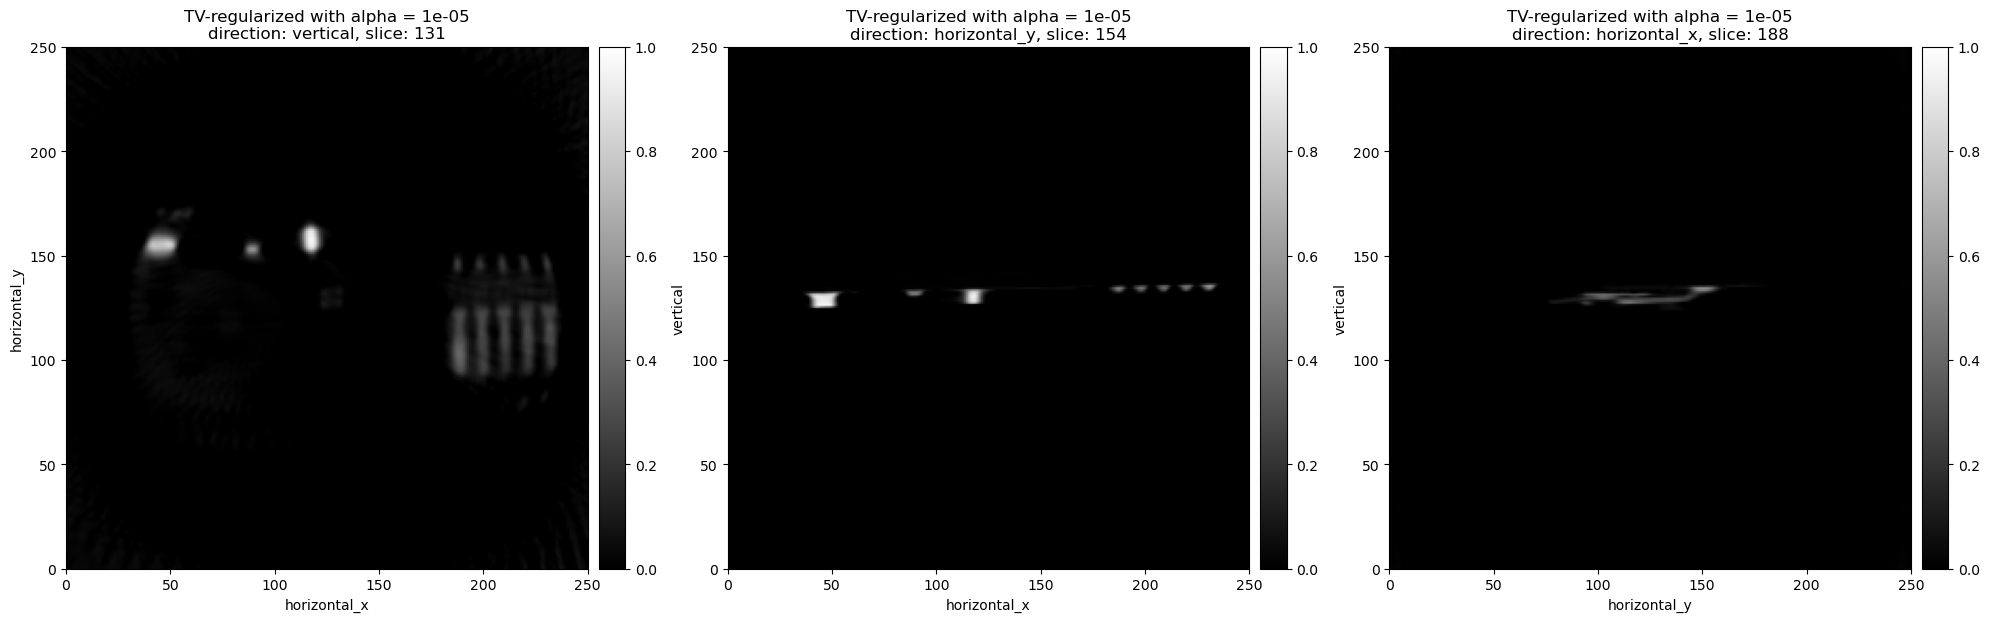

In [15]:
x_tv = tv_fista.get_output()
show2D(x_tv, size=(20, 10), fix_range=(0,ub), cmap='gray', title=f'TV-regularized with {alpha = }', num_cols=3, slice_list=[(0, 131), (1, 154), (2, 188)]);